<a href="https://colab.research.google.com/github/DSPOWER93/Washington-house-price/blob/main/XGBoost_Housing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synopsis

Objective of analysis is to predict house price in Seattle and its neighbouring cities in State Washington.

**Total Data Points used:** 4500

**Train: Test ratio** 80:20

Prediction Accuracy:

* RMSE Test: 158,544
* MSE Test: 27,128,872,211
* MAPE Test: 13.77%
* RMSLE Test: 0.2

Regression Algorithm: XGBoost.

###Import of Libraries and Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
from google.colab import files
from math import log,exp
import statsmodels.api as sm
import xgboost as xgb
import sklearn
from sklearn.model_selection import GridSearchCV   #Perforing grid search
# Importing the dataset.
df = pd.read_csv("https://raw.githubusercontent.com/DSPOWER93/Data/main/Housing_data/data.csv")

### Data Representation Settings

In [2]:
# Dropping the display of Scientific Notations.
# for pandas 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# for Numpys
np.set_printoptions(suppress=True,formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

### Inspecting the Dataframe

In [3]:
# Information about the columns 
print(df.info())
# Null content about df
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

### Inpecting the dataset with Duplicate Records

To see if there are multiple records of same house present in Data, we would be inspecting the granularity of data by Grouping the Dataset count on  `["street","date","yr_built","price"]`. If Countof data has more than one count then we inspect further.

In [4]:
# Checking for Duplicate records.
d = df.groupby(["street","date","yr_built",'price'])['street'].count().to_frame()
d.reset_index(level= [1,2,3], inplace= True)
d.index.name = None
d = d.sort_values(['street'], ascending= False)
print(d.head(3) ) # we can conclude that there are no duplicate records for a house.

                                  date  yr_built      price  street
1 View Ln NE       2014-06-25 00:00:00      2012 309620.000       1
3825 138th Ave SE  2014-05-15 00:00:00      1956 417000.000       1
3834 136th Ave SE  2014-07-09 00:00:00      1955 525000.000       1


### Dropping In-valid Datapoints of target variables

We would inspect target variable in dataset  to see if any datapoint in target variable is holding Null or Zero Values. As Value of any House/real-estate cannot be Zero.

In [5]:
# we would evaluating number of cases. which are valued as Zero.
def price_validation(x):
  if(x <= 0 ):
    x = 'Invalid'
  else:
    x = 'Valid'
  return x

df["zero_price"] = df['price'].apply(price_validation)
zero_price = df.groupby(['zero_price'])["zero_price"].count()
zero_price_prct = (zero_price / zero_price.sum()) *100 

print(zero_price)
print(zero_price_prct)

zero_price
Invalid      49
Valid      4551
Name: zero_price, dtype: int64
zero_price
Invalid    1.065
Valid     98.935
Name: zero_price, dtype: float64


**1% of price datapoints is not having values, hence dropping these data points**

In [6]:
#  Dropping cases which doesn't have Housing Prices.
df = df[(df.zero_price == 'Valid')]

### Visualizing the distribution of Target variable.

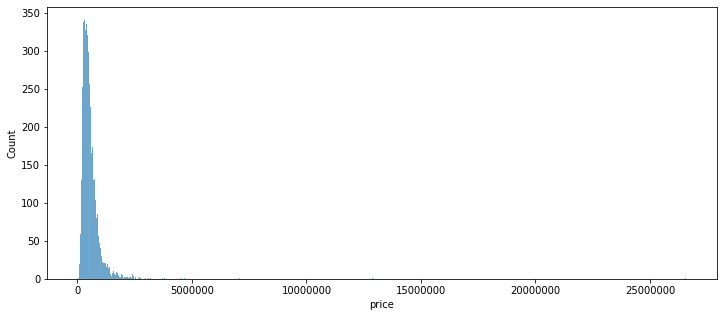

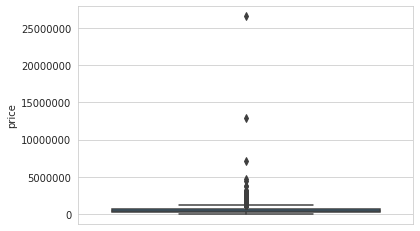

In [7]:
# import of visual library
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


data = df.price

plt.subplots( figsize=(12, 5))
sns.set_style('whitegrid')


ax = sns.histplot(data)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


# Box Plot to check out on the distribution.
sns.boxplot(y = 'price', data = df)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Inference**
Through Histogram and Boxplot we can infer that the Data is highly skewed and needs to be Normalized.


---

#### Normalizing the Distribution.

To Normalize Skewed distribution. We will be applying Log tranformation on Data. 

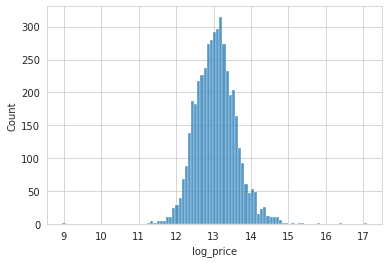

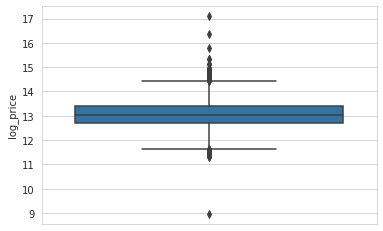

In [8]:
import math


def transform_log(x):
  if(x <= 0):
    x = 1
  return x


def apply_log(x):
  y = math.log(x)
  return y

df['price'] = df.price.apply(transform_log)
df['log_price'] = df.price.apply(apply_log)


sns.set_style('whitegrid')
ax = sns.histplot(x = 'log_price', data = df)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

sns.boxplot(y = 'log_price', data = df)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### Data cleaning and Pre-processing

Linear Regression can handle Numeric Values but we have to convert object/ catagorical variables to Numerics before we proceed head.


```
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object

```



### Country

In [9]:
# Evaluating Country presence.

country  = df.groupby(['country'])['country'].count()
print(country)

print("Dropping Country  as it conatains only one value i.e. USA")
df = df.drop('country', axis = 1)
# print(df.columns)

country
USA    4551
Name: country, dtype: int64
Dropping Country  as it conatains only one value i.e. USA


### City Names

From Dataset City Name it is assured that the whole dataset represents city names located neighbouring to Seattle Washington.

#### EDA Analysis on City to impact on Price.

Visually evaluating if location on the bsis of City is having impact on the price of house. 

##### Through Box Plot

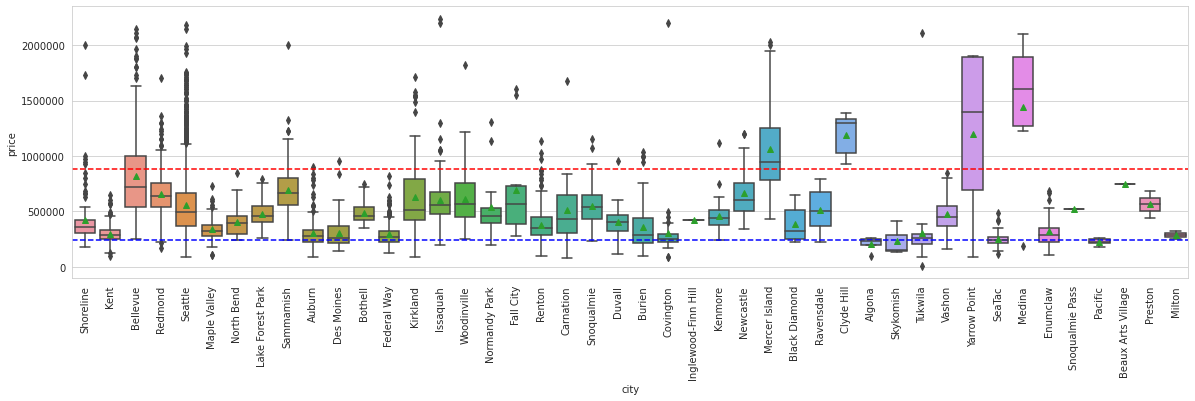

In [10]:
#  removing Outliers from the Data at 99.7%  standard normality rate.
df_price_cap = np.mean(df['price']) + 3 * np.std(df['price'])
df_wo_outliers = df[(df['price'] <= df_price_cap)]

high_quantile_90_quantile = df_wo_outliers['price'].quantile(.90)
high_quantile_10_quantile = df_wo_outliers['price'].quantile(.10)


plt.subplots( figsize=(20, 5))
sns.set_style('whitegrid')
ax = sns.boxplot(x= 'city',y = 'price', 
                 data = df_wo_outliers,
                 showmeans=True)
ax.axhline(high_quantile_90_quantile, ls='--', c= 'r')
ax.axhline(high_quantile_10_quantile, ls='--', c= 'b')
plt.ticklabel_format(style='plain', axis='y')
plt.setp(ax.get_xticklabels(), rotation=90) # to rotate city values by 90*
plt.show()

**Inference :** We applied cap line of 90th quantile (removing  at 3 Sigma from mean) to find out which of the city prices are above 90th Quantile, As prices of from  these cities will have very impact on the data. There are four Cities which are having Median Price above 90th quantile.  `['Mercer Island', 'Clyde Hill', 'Yarrow Point', 'Medina'] `.
Also We will include those cities whose prices are below 10th percentile as not including these variable will not penalize the intercept and model will over predict values for house in these cities. `['Algona', 'Skykomish', 'SeaTac', 'Pacific']`

We would treat these cities into One hot Encoding as price of these cities would highly impact the house prices.

#### Count plot most occured data points for city values. 

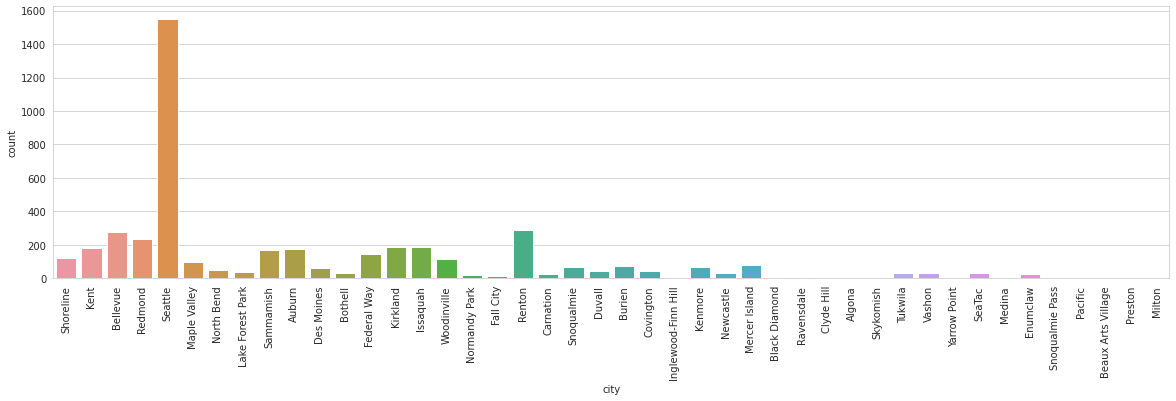

In [11]:
plt.subplots( figsize=(20, 5))
sns.set_style('whitegrid')
ax = sns.countplot(x= 'city', data = df_wo_outliers)
plt.ticklabel_format(style='plain', axis='y')
plt.setp(ax.get_xticklabels(), rotation=90) # to rotate city values by 90*
plt.show()

**Inference**


From the Box Plot it's seen that other than top four cities with high median range most of the other cities house prices are not in distinct high price range. Other than 4 Cities considering 'Seattle' the most popular city for one hot encoding.


In [12]:
#  filtering out only 5 cities.
df_city_OHC = pd.get_dummies(df['city'])

selected_cities = ['Mercer Island', 'Clyde Hill', 'Yarrow Point', 'Medina', 'Seattle','Algona', 'Skykomish', 'SeaTac', 'Pacific']
df_city_OHC = df_city_OHC.loc[:,selected_cities]
df_city_OHC.columns = ['City_Mercer_Island', 'City_Clyde_Hill', 'City_Yarrow_Point', 'City_Medina', 'City_Seattle', 'City_Algona', 'City_Skykomish', 'City_SeaTac', 'City_Pacific']


df = pd.concat([df,df_city_OHC] , axis= 1)
print(df.head(2))

                  date       price  ...  City_SeaTac  City_Pacific
0  2014-05-02 00:00:00  313000.000  ...            0             0
1  2014-05-02 00:00:00 2384000.000  ...            0             0

[2 rows x 28 columns]


### Zip-Codes and Street Address

This varible is most granular categorical variable, we can treat it by importing Gegraphical Cordinates (Long, Lat) data for given Street name for given Zip Code.

#### Import of Lat-Long Data for Street address.

There are two files imported holding geographical details one file contains the Gegraphical Cordinates Data on the basis of  street Address and other file contains cordinates on the basis of Zip-codes. If the Street Geographical data contains null values for cordinates we will replace it with Zip-code Cordinates for the given region.

The code used to extract Cordinate points are mentioned here. [link](https://github.com/DSPOWER93/Python_codes/blob/main/Geo_cordinates/Extract_Geographical_cordinates.ipynb)

In [14]:
zip_code = pd.read_csv("https://raw.githubusercontent.com/DSPOWER93/Data/main/us-zip-code-latitude-and-longitude.csv", sep= ';') 

street_long_lat = pd.read_csv("https://raw.githubusercontent.com/DSPOWER93/Data/main/Washington_housing_data/street_lat_long_file_WA_housing_data.csv", 
                              index_col=0)


print(zip_code.head(2))
print(street_long_lat.head(2))
print(df.head(2))

     Zip     City  ... Daylight savings time flag             geopoint
0  66025   Eudora  ...                          1  38.917032,-95.06455
1  74565  Savanna  ...                          1  34.831398,-95.83967

[2 rows x 8 columns]
                                     address   Lat_    long_
0  18810 Densmore Ave N, Shoreline, WA 98133 47.735 -122.338
1    14013 Ashworth Ave N, Seattle, WA 98133 47.731 -122.340
                  date       price  ...  City_SeaTac  City_Pacific
0  2014-05-02 00:00:00  313000.000  ...            0             0
1  2014-05-02 00:00:00 2384000.000  ...            0             0

[2 rows x 28 columns]


In [15]:
# The Zip code file imported has zip-code values in numeric converting Dataframe Zip-codes only Numeric format removing State Initials from the data.
import re
def only_numeric(x):
  x = int(re.search(r'\d+', x)[0])
  return x
df['zip'] = df.statezip.apply(only_numeric) 

#  Joining with Zip-code Lat-Long Data. 
df = pd.merge(df, zip_code.loc[:, ['Zip','Latitude','Longitude']], how='inner', left_on='zip', right_on = 'Zip')
df = df.drop('Zip', axis = 1)

#  creating a new column of complete address
Complete_address = []

for i in range(df.shape[0]): 
  a = df.iloc[i,14]
  b = df.iloc[i,15]
  c = df.iloc[i,16]
  d = a + ', ' + b + ', ' + c
  Complete_address.append(d)

#  Joining Complete adresss to the Data frame.

df['complete_address'] = Complete_address

# Making sure that none of the duplicate/repeated entires are  not joined. 

street_long_lat = street_long_lat.loc[:,['address','Lat_','long_']].drop_duplicates()

#  Joining with Zip-code Lat-Long Data. 
df = pd.merge(df,street_long_lat , how='left', left_on='complete_address', right_on = 'address').drop('address', axis = 1)

# df = df.drop('Zip', axis = 1)

# To evaluate the dataset >>
df.head(2)
df.isnull().sum()

# repalcing the NAN values in Lat_ and Long_ with Latitude and longititude.
df.Lat_.fillna(df.Latitude, inplace=True)
df.long_.fillna(df.Longitude, inplace=True)

#  Dropping the Non relvant columns.
df.drop(['Latitude', 'Longitude'], axis= 1, inplace= True)

### Visualizing  Location Data. 

As we have got the Geo-points Data we will be plotting on map and visualize the scatter plots. in terms of pricing. 

In [16]:
import folium
import pandas as pd
import folium.plugins

import branca
import branca.colormap as cm

x_start = (df['Lat_'].max() + df['Lat_'].min()) / 2
y_start = (df['long_'].max() + df['long_'].min()) / 2
start_coord = (x_start, y_start)

colormap = cm.LinearColormap(colors=['red','black'],index=[7800,655000], vmin= 7800,vmax=655000)

map = folium.Map(location=start_coord, zoom_start=10)

lat = list(df.Lat_)
lon = list(df.long_)
pow = list(df.price)

for loc, p in zip(zip(lat, lon), pow):
    folium.Circle(
        location=loc,
        radius=5,
        fill=True,
        color=colormap(p),
        fill_opacity=0.7
    ).add_to(map)

map.add_child(colormap)

folium.Circle(
        location= [47.640295 , -122.258628],
        radius=50,
        fill=True,
        color='yellow',
        fill_opacity=2).add_to(map)

folium.Circle(
        location= [47.640295 , -122.258628],
        radius=50,
        fill=True,
        color='yellow',
        fill_opacity=2).add_to(map)



folium.Circle(
        location= [47.489137 , -122.215115],
        radius=50,
        fill=True,
        color='green',
        fill_opacity=2).add_to(map)



display(map)

**Inference**: It can be observed that Houses near Evergreen Floating Bridge are very highly valued (Marked in Yellow on Map). Creating variables that measures distance between Floating Bridge and houses could help the model better in predicting house prices, being relative Negative coefficient to Data (Lesser the distance higher the cost).

Also it is seen that Houses below the latitude of Renton Muncipal Airport (Marked in green on Map) are lower in prices We would create on Hot encodes variable which mark value below Renton Muncipal Airport.

#### Adding Feature: 
* Distance from Evergreen Bridge (Feature Engineering)
* Latitutude Below Renton Muncipal Airport.

As observed from above map that houses near to Evergreen bridge are very high in value creating Feature "`Distance_Evergreen_bridge`" using Radians method to calculate distance between bridge and houses.

Also observed that house prices below Latitude of Renton Muncipal airtport (marked green on Map) are low in values.

In [17]:
# Evergreen Floating bridge
# 47.640295 , -122.258628

from math import acos,cos,radians,sin

# 6371*acos(cos(radians(90-D7))*cos(radians(90-D8))+sin(radians(90-D7))*sin(radians(90-D8))*cos(radians(E7-E8)))

# D7 IS LAT1, E7 IS LONG1, D8 IS LAT2, E8 IS LONG2 


def distance_evergreen_bridge(lat,long):
  D7 =  47.640295 # LAT OF EVERGREEN BRIDGE.
  E7 = -122.258628 # LONG OF EVERGREEN BRIDGE.
  D8 = lat
  E8 = long
  distance = 6371*acos(cos(radians(90-D7))*cos(radians(90-D8))+sin(radians(90-D7))*sin(radians(90-D8))*cos(radians(E7-E8)))
  return distance


df['distance_evergreen_bridge'] = df.apply(lambda x: distance_evergreen_bridge( x.Lat_ , x.long_), axis=1) 

print("Log Price to Evergreen Bridge Distance Corr score: ",df['distance_evergreen_bridge'].corr(df['log_price'])) 

df['below_renton_airport'] = np.where(df.Lat_ < 47.489137,1, 0)

print("Log Price to below renton Airport : ", df['below_renton_airport'].corr(df['log_price']))

Log Price to Evergreen Bridge Distance Corr score:  -0.4555825202073883
Log Price to below renton Airport :  -0.4686474110756303


**Inference** Negative Correlation Indicates Lesser the distance Higher the House prices

In [18]:
#  Checking the Columns in Data Which other columns needs to be preprocessed.
df.head(2)

date  ...  below_renton_airport
0  2014-05-02 00:00:00  ...                     0
1  2014-05-05 00:00:00  ...                     0

[2 rows x 34 columns]

#### **Adding Feature:** 

House Age: Age of House to Present Year (2020)
Renovation age: Age from last Renovation Done(If the house is not renovated then age of House and age of renovation will be same).

We will compare the correlation between both the variables and also eliminate variable through VIF if required.

In [19]:
# House age
df['house_age'] =  2020 - df['yr_built']
# Renovation age
df['renovation_age'] = np.where(df['yr_renovated'] <= 0 ,df['house_age'] , 2020 - df['yr_renovated'] )

# Checking Multi-Collinearity
print(df['house_age'].corr(df['renovation_age'])) # Not that bad to highly correlated to each other we can evaluate from VIF.

0.46227345777449536


In [20]:
#  checking for anomaly in the Data.
print(df[df['house_age'] < 0 ])
print(df[df['renovation_age'] < 0 ])

print(np.max(df['house_age'])) # to see outliers
print(np.max(df['renovation_age'])) # to see outliers

#  Dropping Year Built and Year renovated column
df.drop(['yr_built', 'yr_renovated'], axis= 1, inplace= True)

Empty DataFrame
Columns: [date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated, street, city, statezip, zero_price, log_price, City_Mercer_Island, City_Clyde_Hill, City_Yarrow_Point, City_Medina, City_Seattle, City_Algona, City_Skykomish, City_SeaTac, City_Pacific, zip, complete_address, Lat_, long_, distance_evergreen_bridge, below_renton_airport, house_age, renovation_age]
Index: []
Empty DataFrame
Columns: [date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated, street, city, statezip, zero_price, log_price, City_Mercer_Island, City_Clyde_Hill, City_Yarrow_Point, City_Medina, City_Seattle, City_Algona, City_Skykomish, City_SeaTac, City_Pacific, zip, complete_address, Lat_, long_, distance_evergreen_bridge, below_renton_airport, house_age, renovation_age]
Index: []
120
120


In [21]:
# Evaluating Dataframe and Dropping irrelevant Columns 
df.head(2) 

# To Be Dropped
# Price:  As we are considering Log price 
# Street: As it is categorical variable and we already treated it with adding Lat and Long Data.
# StateZip: Already treated  by using Gegraphical cordinates.
# City: already Treated above by selecting Five cities in One hot encoding.
# zer_price : it is  dummy variable used to filter out data. 
# Lat Long Cordinates Data: We found on Plotting  regarding price correlation with location evergreen Bridge nearness ('distance_evergreen_bridge').
# Complete_address:  for mapping purpose only.
# Date: It is on  record Logged Date 

df.drop([ 'date','price', 'street', 'city' , 'statezip', 'zero_price','zip', 'complete_address'], axis=1,inplace = True)
df.head(2)

bedrooms  bathrooms  ...  house_age  renovation_age
0     3.000      1.500  ...         65              15
1     5.000      2.000  ...         78              62

[2 rows x 26 columns]

In [ ]:
regressor = xgb.XGBRegressor(max_depth=5,n_estimators=200, objective='reg:squarederror')

In [ ]:
regressor

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [23]:
#  Spliting the data into train and test.
X = df.drop('log_price', axis = 1)
Y = df.log_price


from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=0)

In [ ]:
regressor.fit(x_train,y_train, eval_set = [(x_train,y_train), (x_test, y_test)])

[0]	validation_0-rmse:11.3146	validation_1-rmse:11.3386
[1]	validation_0-rmse:10.1856	validation_1-rmse:10.2082
[2]	validation_0-rmse:9.16944	validation_1-rmse:9.19236
[3]	validation_0-rmse:8.25509	validation_1-rmse:8.27834
[4]	validation_0-rmse:7.43215	validation_1-rmse:7.45493
[5]	validation_0-rmse:6.6916	validation_1-rmse:6.71456
[6]	validation_0-rmse:6.02522	validation_1-rmse:6.04743
[7]	validation_0-rmse:5.42547	validation_1-rmse:5.44712
[8]	validation_0-rmse:4.88585	validation_1-rmse:4.90589
[9]	validation_0-rmse:4.40026	validation_1-rmse:4.42004
[10]	validation_0-rmse:3.9633	validation_1-rmse:3.98185
[11]	validation_0-rmse:3.57031	validation_1-rmse:3.58923
[12]	validation_0-rmse:3.2167	validation_1-rmse:3.23492
[13]	validation_0-rmse:2.89854	validation_1-rmse:2.91611
[14]	validation_0-rmse:2.6124	validation_1-rmse:2.62942
[15]	validation_0-rmse:2.35506	validation_1-rmse:2.37184
[16]	validation_0-rmse:2.12363	validation_1-rmse:2.14043
[17]	validation_0-rmse:1.91561	validation_1-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

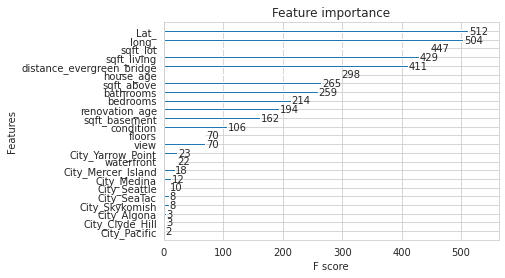

In [ ]:
xgb.plot_importance(regressor)
plt.show()

In [ ]:
train_prediction = regressor.predict(x_train) 
test_prediction =  regressor.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error

print("RMSE train: {0:.2f}".format(mean_squared_error(np.exp(y_train),
                                                    np.exp(train_prediction) )**.5))

print("RMSE test: {0:.2f}".format(mean_squared_error(np.exp(y_test),
                                                    np.exp(test_prediction) )**.5))

RMSE train: 359775.38
RMSE test: 157273.59


In [ ]:
#MAPE Value calculation
def mape(act,pred):
    x = np.abs(1-pred/act)*100
    return(round(np.mean(x),2))

In [ ]:
trainmape = mape(np.exp(y_train),np.exp(train_prediction))
testmape=mape(np.exp(y_test),np.exp(test_prediction))

print("Train MAPE is : " + str(trainmape) + "%")
print("Test MAPE is : " + str(testmape) + "%")

In [ ]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

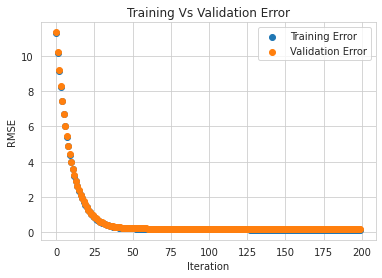

In [ ]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

### Model Hypertuning

In [ ]:
xgb_model = xgb.XGBRegressor(subsample=0.8, objective = 'reg:squarederror')

# max_depth=5,n_estimators=150

# Setting n_jobs to -1 using all processor threads
'''
verbose: int
Controls the verbosity: the higher, the more messages.
>1 : the computation time for each fold and parameter candidate is displayed;
>2 : the score is also displayed;
>3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.
'''

params = {
    'max_depth': [3,4,5,6], # leaf nodes in the trees
    'n_estimators': [150,200], # number of total trees for total number of iterations
    'gamma': [0,15,50,100], # penalizing the similarity score
    'reg_alpha': [0,1,2], 
    'reg_lambda': [1,2,3]
}

# Scoring in Gridsearch CV always considers higher the better, so it multplies the rmse score with negative so that we achive the lowest rmse score.
# thats why it is using negated version of rmse. e.g. -1000 will be better than -10000

clf = GridSearchCV(xgb_model,  n_jobs=-1, 
                   cv= 5, 
                   scoring='neg_root_mean_squared_error',
                   param_grid = params,
                   verbose=2)

In [ ]:
clf.fit(x_train,y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 14.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 15, 50, 100], 'max_depth': [3, 4, 5, 6],
                         'n_estimators': [150, 

#### Best Model Parameters

In [ ]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=2, reg_lambda=2, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [ ]:
# XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, gamma=0,
#              importance_type='gain', learning_rate=0.1, max_delta_step=0,
#              max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
#              n_jobs=1, nthread=None, objective='reg:squarederror',
#              random_state=0, reg_alpha=2, reg_lambda=2, scale_pos_weight=1,
#              seed=None, silent=None, subsample=0.8, verbosity=1)

In [ ]:
xgb_best_fit = clf.best_estimator_

In [ ]:
train_prediction_1 = xgb_best_fit.predict(x_train) 
test_prediction_1 =  xgb_best_fit.predict(x_test)

In [ ]:
print("RMSE train: {0:.2f}".format(mean_squared_error(np.exp(y_train),
                                                    np.exp(train_prediction_1) )**.5))

print("RMSE test: {0:.2f}".format(mean_squared_error(np.exp(y_test),
                                                    np.exp(test_prediction_1) )**.5))

RMSE train: 486914.09
RMSE test: 158544.10


### MAPE Score

In [ ]:
trainmape_2 = mape(np.exp(y_train),np.exp(train_prediction_1))
testmape_2 =mape(np.exp(y_test),np.exp(test_prediction_1))

print("Train MAPE is : " + str(trainmape_2) + "%")
print("Test MAPE is : " + str(testmape_2) + "%")

Train MAPE is : 12.68%
Test MAPE is : 13.77%


### Feature Importance by XGboost Algorithm

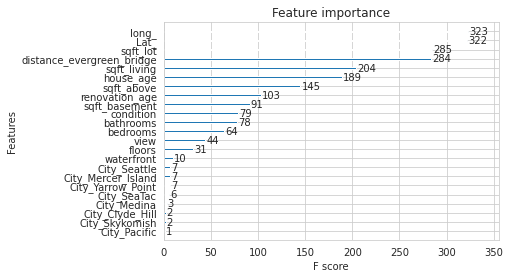

In [ ]:
xgb.plot_importance(xgb_best_fit)
plt.show()

In [24]:
x_train.head(2)

bedrooms  bathrooms  ...  house_age  renovation_age
3707     3.000      1.750  ...         35              35
2601     4.000      2.500  ...         21              21

[2 rows x 25 columns]

### Importing best model

In [25]:
!git clone https://github.com/DSPOWER93/Washington-house-price.git

Cloning into 'Washington-house-price'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 69 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (69/69), done.


In [40]:
import joblib
from sklearn.metrics import mean_squared_log_error, mean_squared_error

xgb_model = joblib.load('/content/Washington-house-price/Xgboost.sav')
deploy_test_prediction =  xgb_model.predict(x_test)
print("RMSLE Score: ", np.sqrt(mean_squared_log_error(np.exp(y_test), np.exp(deploy_test_prediction))))
print("MSE Score:", mean_squared_error(np.exp(y_test), np.exp(deploy_test_prediction)))

RMSLE Score:  0.2052375674590345
MSE Score: 27128872210.85031


QQ Plot 

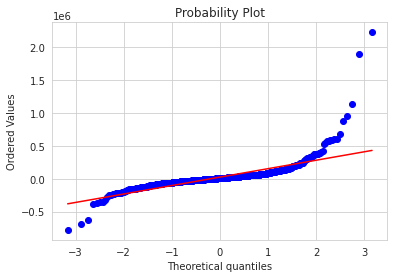

In [30]:
import scipy.stats as stats
import pylab


residuals = np.exp(y_test) - np.exp(deploy_test_prediction)

stats.probplot( residuals , dist="norm", plot=pylab)
pylab.show()

**Inference**
Due to Outliers  the chart has zoomed out, and residual distriution looks straight line to zero major of residual distribution is fitting on the line.
We can replot and see removing the Outliers (at ±2σ)    

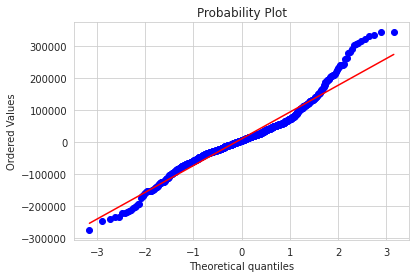

In [31]:
# replotting Removing Outliers  
residual_wo_outliers_bool = (residuals >= (np.mean(residuals) - 2 * np.std(residuals))) & (residuals <= (np.mean(residuals) + 2 * np.std(residuals)))
residual_wo_outliers = residuals[residual_wo_outliers_bool]
stats.probplot( residual_wo_outliers , dist="norm", plot=pylab)
pylab.show()

**Inference**

Considering the limitation of of the Linear algorithm. the model has been efficient in predicting the in the Data quantile range from ( -2σ to +2σ). however has not been efficient for  predicting outlier prices. 

### Heteroscedasticity of residuals

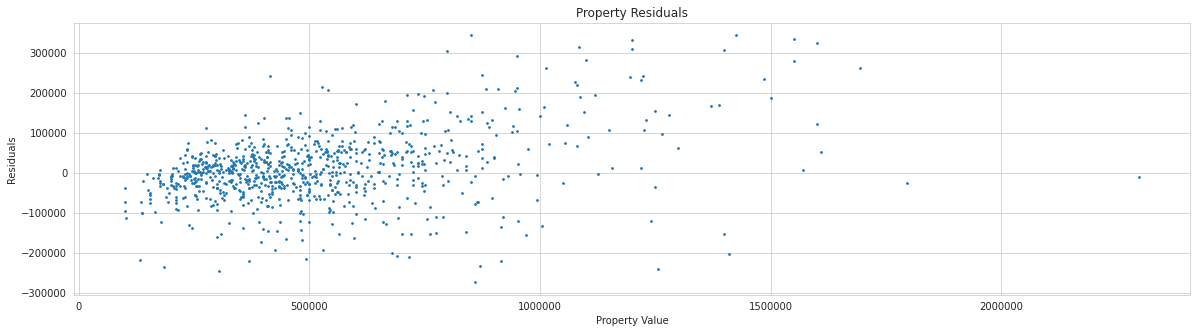

In [36]:
plt.subplots( figsize=(20, 5))
sns.set_style('whitegrid')

plt.scatter( x= np.exp(y_test[residual_wo_outliers_bool]),y= residual_wo_outliers, s = 3)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Property Value")
plt.ylabel("Residuals")
plt.title("Property Residuals")
plt.show()

**Inference**
 - Model results are having high residuals for prediticing high end property price.
 - Model is tilting towards over prediction for property value above 500,000 

###  Residual Distribution on test Data.

**Objective:** To see the Residual distribution accross Different House Price Ranges.

In [41]:

from math import floor
# Range of 100,000

y_train_floor = np.hstack(np.floor( np.array(np.exp(y_test)) /100000) *100000)


# In case you would like represent the distribution in terms of range replace 'y_train_floor' with  'y_train_range'
y_train_range = np.core.defchararray.add(y_train_floor.astype(str), np.repeat(' - ',len(y_train_floor)))
y_train_range = np.core.defchararray.add(y_train_range,(100000+y_train_floor).astype(str)) 



residual_distribution = pd.DataFrame({'y_test_floor' : np.round(y_train_floor,0).astype(int),
                                      'y_train' : np.exp(y_test),
                                      'Over_predicted' : np.where(residuals < 0, 1,0  ),
                                      'Under_predicted': np.where(residuals >= 0, 1,0 ),
                                      'Error_delta': np.abs(1 - np.exp(deploy_test_prediction)/np.exp(y_test))*100})


In [42]:
residual_presentation = residual_distribution.groupby(['y_test_floor'])['Over_predicted','Under_predicted','Error_delta'].agg(['sum','mean'])
residual_presentation.columns = residual_presentation.columns.map('_'.join)
residual_presentation = residual_presentation.reset_index()

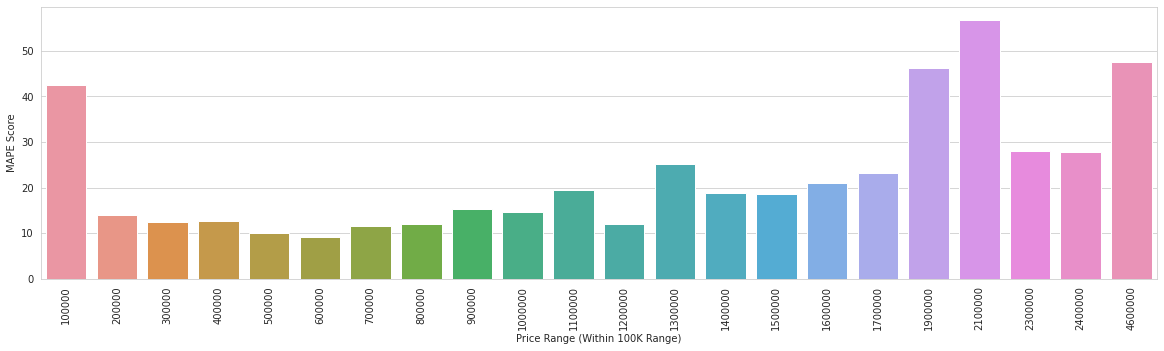

In [43]:
plt.subplots( figsize=(20, 5))
sns.set_style('whitegrid')
ax = sns.barplot('y_test_floor','Error_delta_mean', data = residual_presentation)
plt.setp(ax.get_xticklabels(), rotation=90) # to rotate city values by 90*
plt.xlabel('Price Range (Within 100K Range)')
plt.ylabel('MAPE Score')
plt.show()

**Inference**

It is Seen that Few of Price range are Highly Impacting the Mape score of the Model. Particaularly Ranges:
1. 0 - 00,000
2. 1.9 Mlns


Model failing to predict property values at higher price range might be due outliers present in data.

#### Under Prediction / Over Prediction accross House Price Range.

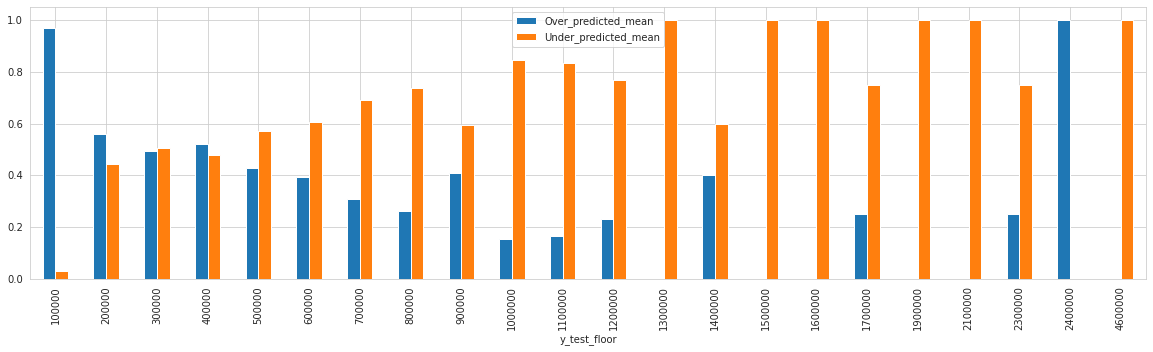

In [44]:
residual_presentation.plot(x = 'y_test_floor', y = ['Over_predicted_mean', 'Under_predicted_mean'], kind = 'bar',figsize=(20,5))
plt.show()

**Inference**


*   Model is highly Over predicting price at initial interval.
*   Model Predications are highly under-prediction at higher ranges.



### End